<a href="https://colab.research.google.com/github/shlomi1993/deep-learning-notebooks/blob/main/6_conv2d_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 6 - Conv2D Transfer Learning

## Introduction

In this notebook, we explore several core concepts in deep learning using PyTorch, including custom layer implementation, backpropagation through convolutional layers, and transfer learning.

In the first part, we implement a custom 2D convolutional layer from scratch, supporting both padding and stride functionality, without relying on `torch.nn` modules.

The second part involves deriving the mathematical formulation for the gradient propagation through the convolution operation, an essential component for training neural networks.

Finally, in the third and most extensive part, we apply transfer learning by adapting a pre-trained ResNet model to classify images from the CIFAR-10 dataset. We also analyze model performance, visualize misclassifications, and design and train a new custom architecture to compare with the adapted ResNet model.

Throughout the task, we follow best practices in deep learning and PyTorch to implement, train, and evaluate our models effectively.

## Implement Conv2D Layer

In this part, we are asked to implement a custom 2D convolutional layer using PyTorch, without relying on built-in layers such as `nn.Conv2d` or built-in padding functions. The layer should support padding and stride, and behave similarly to `nn.Conv2d`.


### Class Definition

In [ ]:
import torch
import torch.nn as nn

class Conv2d(nn.Module):
    def __init__(
        self,
        in_channels: int = 1,
        out_channels: int = 1,
        kernel_size: tuple[int, int] = (1, 1),
        stride: int = 1,
        padding: int = 0
    ) -> None:
        """
        Initializes a custom 2D convolution layer with padding and stride support.

        The weights are initialized with a random normal distribution, and the biases are initialized with a uniform
        distribution based on the kernel size. These parameters are wrapped in nn.Parameter to make them learnable
        during training.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            kernel_size (tuple[int, int]): Size of the convolution kernel.
            stride (int): Stride of the convolution (same for height and width).
            padding (int): Number of zero-padding layers to add on all sides of the input.
        """
        super(Conv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialize learnable weights and biases parameters
        kernel_height, kernel_width = kernel_size
        self.weights = nn.Parameter(torch.randn(out_channels, in_channels, kernel_height, kernel_width))
        bound = 1 / (kernel_height * kernel_width) ** 0.5  # Formula from study guide
        self.biases = nn.Parameter(torch.empty(out_channels).uniform_(-bound, bound))

    def _pad(self, x: torch.Tensor, padding: int) -> torch.Tensor:
        """
        Pads the input tensor with zeros on all sides.

        The padding is applied symmetrically to the height and width dimensions of the input tensor.
        Specifically, the input tensor's height and width are each extended by `padding` number of rows/columns
        on both the top/bottom and left/right sides.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).
            padding (int): Number of zero-padding layers to add to each side of the height and width dimensions.

        Returns:
            torch.Tensor: Zero-padded tensor of shape
            (batch_size, in_channels, height + 2 * padding, width + 2 * padding).
        """
        if padding == 0:
            return x

        padded_shape = (
            x.size(0),  # batch_size
            x.size(1),  # in_channels
            x.size(2) + 2 * padding,  # height
            x.size(3) + 2 * padding   # width
        )
        padded = torch.zeros(padded_shape, dtype=x.dtype, device=x.device)
        padded[:, :, padding:-padding, padding:-padding] = x
        return padded

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the convolution operation on the input tensor.

        This method first pads the input tensor using the _pad() method to handle border effects. It then uses the
        unfold() function to extract sliding patches from the input tensor based on the kernel size and stride,
        reshaping them for matrix multiplication. The patches are multiplied by the weights, and the biases are added
        (broadcasted if necessary). Finally, the output is reshaped to the required dimensions, returning the tensor
        with the computed convolution.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, height, width).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, out_channels, out_height, out_width).
        """
        batch_size, _, input_height, input_width = x.shape
        kernel_height, kernel_width = self.kernel_size

        # Padd the input tensor
        x_padded = self._pad(x, self.padding)

        # Unfold to extract sliding patches
        x_unfolded = x_padded.unfold(2, kernel_height, self.stride).unfold(3, kernel_width, self.stride)
        out_h, out_w = x_unfolded.shape[2], x_unfolded.shape[3]

        # Rearrange to (batch, out_h * out_w, in_channels * kernel_height * kernel_width)
        x_unfolded = x_unfolded.contiguous().view(batch_size, self.in_channels, out_h, out_w, kernel_height * kernel_width)
        x_unfolded = x_unfolded.permute(0, 2, 3, 1, 4).reshape(batch_size, out_h * out_w, -1)

        # Reshape weights to (out_channels, in_channels * kernel_height * kernel_width)
        weights_flat = self.weights.view(self.out_channels, -1)

        # Perform batched matrix multiplication: (batch, out_h * out_w, out_channels)
        out = x_unfolded @ weights_flat.t()  # (B, H * W, Cout)
        out = out + self.biases  # broadcast bias

        # Reshape to (batch_size, out_channels, out_h, out_w)
        return out.view(batch_size, out_h, out_w, self.out_channels).permute(0, 3, 1, 2)

#### Implementation Notes

- This implementation creates a custom 2D convolution layer by subclassing `nn.Module`, as requested in **section 1.1**.

- The `__init__` method initializes the layer with the parameters `in_channels`, `out_channels`, `kernel_size`, `stride`, and `padding`, as requested in **section 1.2**.

- These parameters define the number of input and output channels, the kernel size, the stride, as requested in **section 1.3**, and the padding, as requested in **section 1.4**.

- The `forward` method applies the convolution. First, it pads the input tensor using the `_pad()` method, ensuring symmetrical padding on all sides. The method then uses `unfold()` to extract patches from the padded input, reshapes them for matrix multiplication with the kernel weights, and adds the biases. The output is reshaped and returned. This implementation does not use any functions from `torch.nn`, as requested in **section 1.5**.


### Test Conv2D Class

To compare our custom Conv2d layer with PyTorch's built-in Conv2d layer, we will first define a few consts:

In [ ]:
in_channels = 3
out_channels = 64
kernel_size = (3, 3)
stride = 1
padding = 1

We instantiate both the custom `Conv2d` layer and the PyTorch `Conv2d` layer

In [ ]:
custom_con2d = Conv2d(in_channels, out_channels, kernel_size, stride, padding)
torch_conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

To ensure that the custom convolution layer (`custom_con2d`) starts with the same initialized weights and biases as the standard PyTorch `Conv2d` layer (`torch_conv2d`), we need to manually copy the parameters from the PyTorch layer to the custom layer. This step guarantees that both layers begin with identical values, allowing us to fairly compare their behavior and performance.

In [ ]:
custom_con2d.weights.data = torch_conv2d.weight.data.clone()
custom_con2d.biases.data = torch_conv2d.bias.data.clone()

Now, we create a random input tensor and pass it through both the custom and PyTorch `Conv2d` layers to obtain their respective outputs for comparison.

In [ ]:
input_tensor = torch.randn(1, in_channels, 32, 32)
out1 = custom_con2d(input_tensor)
out2 = torch_conv2d(input_tensor)
out1.shape, out2.shape

(torch.Size([1, 64, 32, 32]), torch.Size([1, 64, 32, 32]))

We can see that both output tensors have the same shape: (1, 64, 32, 32), indicating that the custom Conv2d layer and PyTorch's Conv2d layer produce outputs of matching dimensions.

Now let's compare the outputs by verifying that both produce nearly identical results given the same weights, biases, and input.

#### Compare outputs

We compute the maximum absolute difference between the outputs of the custom and PyTorch Conv2d layers. This helps us quantify how similar the outputs are.

In [ ]:
max_diff = torch.abs(out1 - out2).max().item()
print(f"Max absolute difference: {max_diff:.6f}")
assert torch.allclose(out1, out2, atol=1e-6), "Outputs are not close enough!"
print("✅ Outputs match!")

Max absolute difference: 0.000000
✅ Outputs match!


## Backpropagation Through a Convolution Layer



This part focuses on computing the gradients of a convolutional layer as part of the backpropagation process. We're given a single-channel input image $X$ of size $3 \times 3$, and a convolutional kernel $K$ of size $2 \times 1$. The output of the convolution is denoted by $Y$, and we are asked to compute $\frac{\partial C}{\partial K}$ and $\frac{\partial C}{\partial X}$, given $\frac{\partial C}{\partial y_{i,j}}$ for all $i,j$.

Given:
- Input image $X$ is of size $3 \times 3$
- Kernel $K$ is of size $2 \times 1$ (i.e., height = 2, width = 1)
- No padding is mentioned, so we assume no padding
- Stride is not specified, so we assume stride = 1
- $\frac{\partial C}{\partial y_{i,j}}$ is the gradient of the loss $C$ w.r.t each output pixel $y_{i,j}$

Then, the output $Y$ will have spatial dimensions:

- $\text{Height}_Y = 3 - 2 + 1 = 2$
- $\text{Width}_Y = 3 - 1 + 1 = 3$

Hence,
$$
Y \in \mathbb{R}^{2 \times 3}
$$

The convolution operation is defined as:

$$
y_{i,j} = \sum_{m=0}^{1} \sum_{n=0}^{0} K_{m,n} \cdot X_{i+m, j+n}
= K_{0,0} \cdot X_{i,j} + K_{1,0} \cdot X_{i+1,j}
$$

So each output $y_{i,j}$ depends on a vertical slice of the input: $X_{i,j}$ and $X_{i+1,j}$.

We now compute:

1. $\frac{\partial C}{\partial K_{a,b}}$ — the gradient of the loss with respect to each kernel element
2. $\frac{\partial C}{\partial X_{m,n}}$ — the gradient of the loss with respect to each input pixel

**Gradient w.r.t. Kernel $K$:**

We apply the chain rule:

$$
\frac{\partial C}{\partial K_{a,0}} = \sum_{i=0}^{1} \sum_{j=0}^{2} \frac{\partial C}{\partial y_{i,j}} \cdot \frac{\partial y_{i,j}}{\partial K_{a,0}}
$$

From the forward pass:

$$
\frac{\partial y_{i,j}}{\partial K_{0,0}} = X_{i,j} \quad \frac{\partial y_{i,j}}{\partial K_{1,0}} = X_{i+1,j}
$$

So:

$$
\frac{\partial C}{\partial K_{0,0}} = \sum_{i=0}^{1} \sum_{j=0}^{2} \frac{\partial C}{\partial y_{i,j}} \cdot X_{i,j}
$$

$$
\frac{\partial C}{\partial K_{1,0}} = \sum_{i=0}^{1} \sum_{j=0}^{2} \frac{\partial C}{\partial y_{i,j}} \cdot X_{i+1,j}
$$

**Gradient w.r.t. Input $X$:**

Now we compute the gradient of the loss with respect to each input pixel $X_{m,n}$.

Each pixel $X_{m,n}$ can affect two different outputs: any $y_{i,j}$ for which $X_{m,n}$ is part of the slice used to compute $y_{i,j}$.

From the convolution rule:

- $y_{i,j}$ uses $X_{i,j}$ and $X_{i+1,j}$

So $X_{m,n}$ contributes to:
- $y_{m,n}$ via $K_{0,0}$, if $0 \leq m \leq 1$
- $y_{m-1,n}$ via $K_{1,0}$, if $1 \leq m \leq 2$

Hence, the total gradient is:

$$
\frac{\partial C}{\partial X_{m,n}} =
\begin{cases}
\frac{\partial C}{\partial y_{m,n}} \cdot K_{0,0} & \text{if } m \in \{ 0,1 \} \\
\frac{\partial C}{\partial y_{m-1,n}} \cdot K_{1,0} & \text{if } m \in \{ 1,2 \} \\
\end{cases}
$$

We sum both terms when $m = 1$, since that pixel participates in both cases.

**Summary:**

- **Gradient w.r.t. Kernel**:

$$
\frac{\partial C}{\partial K_{0,0}} = \sum_{i=0}^{1} \sum_{j=0}^{2} \frac{\partial C}{\partial y_{i,j}} \cdot X_{i,j}
$$

$$
\frac{\partial C}{\partial K_{1,0}} = \sum_{i=0}^{1} \sum_{j=0}^{2} \frac{\partial C}{\partial y_{i,j}} \cdot X_{i+1,j}
$$

- **Gradient w.r.t. Input**: For each $X_{m,n}$:

$$
\frac{\partial C}{\partial X_{m,n}} =
\begin{cases}
\frac{\partial C}{\partial y_{m,n}} \cdot K_{0,0} & \text{if } m \in \{0,1\} \\
\frac{\partial C}{\partial y_{m-1,n}} \cdot K_{1,0} & \text{if } m \in \{1,2\}
\end{cases}
$$

## Transfer Learning for CIFAR-10

In this part, we explore **transfer learning** by utilizing a pretrained deep convolutional neural network to classify images from a new dataset. Specifically, we will use a pretrained **ResNet-18** model, originally trained on the large-scale ImageNet dataset, and adapt it to classify images from the **CIFAR-10 dataset**. The CIFAR-10 dataset consists of 60,000 colored images from size $32 \times 32$ pixels across 10 distinct classes.

We will go through the following stages:

1. Load and explore the CIFAR-10 dataset.

2. Visualize sample images from each class.

3. Load a pretrained ResNet-18 model and modify its classifier head.

4. Fine-tune the classifier head using the CIFAR-10 training set while freezing all other layers.

5. Evaluate the model performance, identify the most confident misclassifications, and visualize them.

6. Design and train a new custom residual CNN from scratch.

7. Compare its performance with the transfer learning approach.

### Load the CIFAR-10 Dataset

In this section, we create a PyTorch Dataset objects based on the CIFAR-10 dataset using the `torchvision.datasets.CIFAR10` function.

First, we define the transformation that performs resizing, converting to a tensor, and normalizing.

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-18 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

**Note:** We use the normalization values `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]` according to the assignment instructions, and based on the information provided in the [official PyTorch transfer learning tutorial](https://docs.pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). These values correspond to the per-channel mean and standard deviation of the ImageNet training set, and are used to match the input distribution expected by pretrained models like ResNet-18, which improves their performance when applied to new data.

Now, we load the CIFAR-10 training and test datasets

In [ ]:
from torchvision import datasets

dataset_dir = './data'

train_set = datasets.CIFAR10(root=dataset_dir, train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root=dataset_dir, train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


In [ ]:
len(train_set), len(test_set)

(50000, 10000)

As we can see, there are 50,000 examples in the train set and 10,000 examples in the test set.

Wrap train and test sets in DataLoaders for iteration

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64  # Common batch size for image classification tasks

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)   # Shuffling the train-set to get better generalization
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)    # No need to shuffle the test-set as evaluation should be deterministic

In [ ]:
len(train_loader), len(test_loader)

(782, 157)

After batching, we have 782 batches of 64 images each in the train set, and 157 batches of 64 images each in the test set.

### Understand the Dataset

According to the [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) article by Alex Krizhevsky, the CIFAR-10 dataset is a popular collection of 60,000 color images sized 32x32 pixels, categorized into 10 mutually exclusive classes such as airplane, automobile, bird, cat, and dog. The dataset contains 50,000 training images and 10,000 test images, organized into five training batches and one test batch. Each batch holds 10,000 images, with the test batch balanced to include exactly 1,000 images per class. Labels are numeric values from 0 to 9 corresponding to the class names.

Created by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton as part of the larger 80 million tiny images dataset, CIFAR-10 serves as a standard benchmark for image classification tasks. Each image is stored as raw pixel values in red, green, and blue channels, and the dataset is available in Python, Matlab, and binary formats. A related dataset, CIFAR-100, contains 100 classes grouped into 20 superclasses, but CIFAR-10 remains widely used for simpler classification problems.

#### Explore the data

In [ ]:
train_set.data.shape, train_set.data.dtype

((50000, 32, 32, 3), dtype('uint8'))

array([[[ 59,  62,  63],
        [ 43,  46,  45],
        [ 50,  48,  43],
        ...,
        [158, 132, 108],
        [152, 125, 102],
        [148, 124, 103]],

       [[ 16,  20,  20],
        [  0,   0,   0],
        [ 18,   8,   0],
        ...,
        [123,  88,  55],
        [119,  83,  50],
        [122,  87,  57]],

       [[ 25,  24,  21],
        [ 16,   7,   0],
        [ 49,  27,   8],
        ...,
        [118,  84,  50],
        [120,  84,  50],
        [109,  73,  42]],

       ...,

       [[208, 170,  96],
        [201, 153,  34],
        [198, 161,  26],
        ...,
        [160, 133,  70],
        [ 56,  31,   7],
        [ 53,  34,  20]],

       [[180, 139,  96],
        [173, 123,  42],
        [186, 144,  30],
        ...,
        [184, 148,  94],
        [ 97,  62,  34],
        [ 83,  53,  34]],

       [[177, 144, 116],
        [168, 129,  94],
        [179, 142,  87],
        ...,
        [216, 184, 140],
        [151, 118,  84],
        [123,  92,  72]]], dtype=uint8)
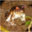

In [ ]:
train_set.data[0]

In [ ]:
train_set.targets[:10], len(train_set.targets)

([6, 9, 9, 4, 1, 1, 2, 7, 8, 3], 50000)

In [ ]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Insights:

1. The CIFAR-10 training dataset contains **50,000** images.

2. Each image has a shape of **32x32** pixels with **3 color channels** (RGB).

3. Image data is stored as **unsigned 8-bit integers (uint8)**, representing raw pixel values.

4. The labels array contains 50,000 **integer class indices**, one per image.

5. There are **10 classes** in total, named: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck.
 - Note that some classes share visual or semantic similarities — for example, "truck" and "automobile" are both vehicles, which can make classification challenging.

6. Each label is an **integer between 0 and 9**, corresponding to these class names.

### Plot Samples

To visualize samples from each class in the CIFAR-10 dataset, we use the `pyplot.imshow()` function from `matplotlib` to display images. We select several images from each of the 10 classes and plot them in a grid, labeling each with its class name. The goal is to understand the variety and visual characteristics of the dataset.

#### Plot samples

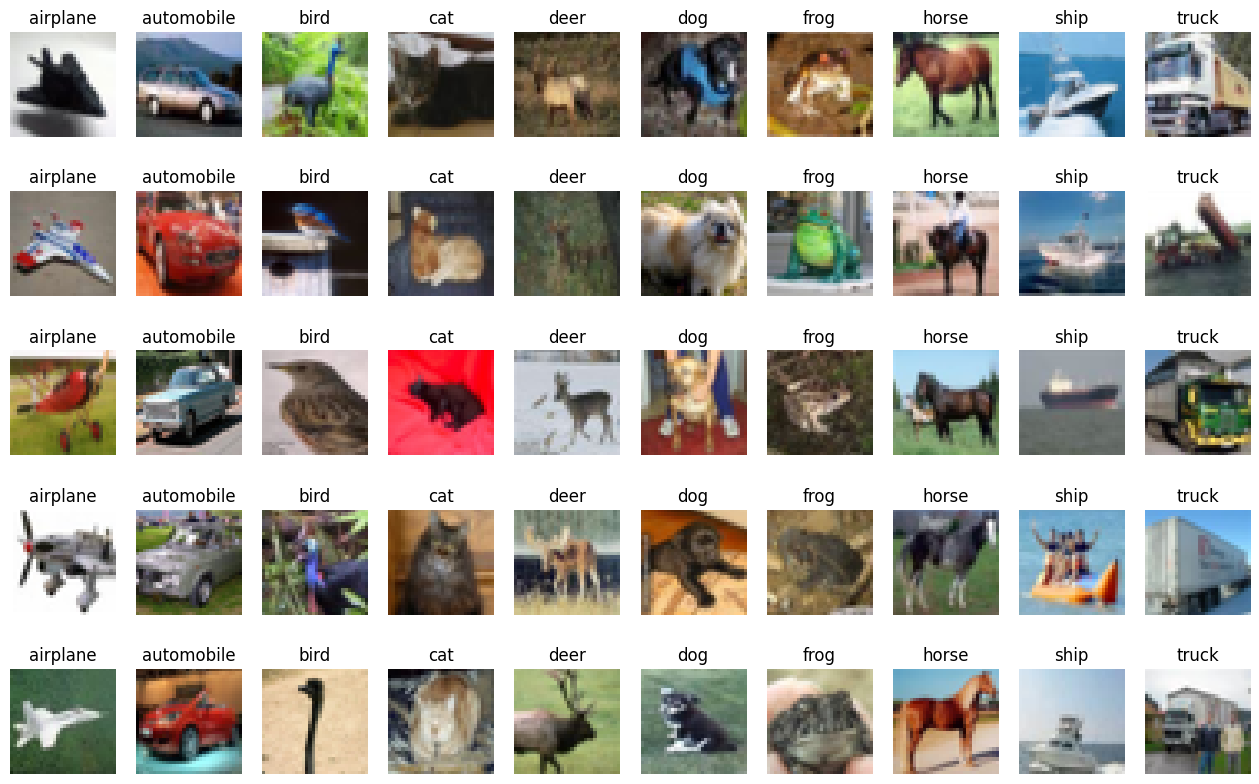

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = np.array(train_set.targets)  # Extract the labels from the training set
classes = np.unique(labels)
n_classes = len(classes)
samples_per_class = 5

plt.figure(figsize=(16, 10))

# Loop through each class and display sample images
for i, cls in enumerate(classes):
    indices = np.where(labels == cls)[0]
    selected_indices = indices[:samples_per_class]
    for j, idx in enumerate(selected_indices):
        plt_idx = j * n_classes + i + 1
        plt.subplot(samples_per_class, n_classes, plt_idx)
        img = train_set.data[idx]
        plt.imshow(img)  # Use imshow() as requested
        plt.axis('off')
        plt.title(train_set.classes[cls])

plt.show()

### Load a Pretrained ResNet-18 Model

Load pretrained ResNet-18

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
resnet18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can get a sense of the network by examining its architecture. In particular, we can see that the model's classifier head is a fully connected (`Linear`) layer named `fc` with 512 units.

### Change Classification Head

We can use the method `model.named_children()`, which returns a generator of named child modules. The last element in this generator corresponds to the classifier head.

In [ ]:
head_name, head_layer = list(resnet18.named_children())[-1]
print(f"Head name: {head_name}")
print(f"Head layer: {head_layer}")

Head name: fc
Head layer: Linear(in_features=512, out_features=1000, bias=True)


Before replacing the model's classification head, we freeze all existing model parameters to prevent them from being updated during training.

In [ ]:
for param in resnet18.parameters():
    param.requires_grad = False

We replace the classifier head with a new one for CIFAR-10

In [ ]:
print(f"Create a fully-connected layer from {resnet18.fc.in_features} units to {len(classes)} output neurons")
resnet18.fc = nn.Linear(resnet18.fc.in_features, len(classes))

Create a fully-connected layer from 512 units to 10 output neurons


Set the classification head's parameters to be trainable.

In [ ]:
for param in resnet18.fc.parameters():
    param.requires_grad = True

This way, only the classification head remains trainable while all other parameters are frozen.

Note that the rest of the model remains unchanged. We can confirm this by inspecting the architecture again:

In [ ]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can see that the last layer has been modified to output only 10 classes, compared to the original 1000-class output.

### Fine Tuning

In this section, we train only the new classification head to recognize the classes of the CIFAR-10 dataset.

#### Optimizer and Learning Rate Selection

**Adam** is a commonly used optimizer for this kind of task, so we instantiate an Adam optimizer to optimize the parameters of the final layer.

Regarding the learning rate, after testing several typical values — 0.1, 0.001, and 0.0001 — it appears that **0.001** delivered the best performance, making it a suitable choice for training.

In [ ]:
from torch import optim

optimizer = optim.Adam(resnet18.fc.parameters(), lr=0.001)

#### Loss Function Selection

We use the cross-entropy loss function as we are dealing with a multi-class classification task.

In [ ]:
criterion = nn.CrossEntropyLoss()

#### Accelerator Device Utilization

Use a GPU if avalable

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Plot Performance Function

Before training the model, we define a function that takes lists of losses and accuracies as input and plots the model's performance.

In [ ]:
def plot_performance(losses: list[float], accuracies: list[float], title: str) -> None:
    """
    Plot loss and accuracy over epochs.

    Args:
        losses (list[float]): A list of loss values for each epoch.
        accuracies (list[float]): A list of accuracy values (in %) for each epoch.
        title (str): Title for the entire plot (figure).
    """
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.suptitle(title, fontsize=16)  # Set the overall figure title

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o')
    plt.title('Loss per Epoch')  # Simpler subplot titles
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, marker='o', color='green')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.98])  # Adjust layout to make room for suptitle
    plt.show()

#### Model Training

Train only the new classification head

In [ ]:
import time
from tqdm.notebook import tqdm

n_epochs = 5

resnet18.train()  # Set the model to training mode (enables dropout, batchnorm updates, etc.)

train_losses = []
train_accuracies = []

for epoch in range(1, n_epochs + 1):
    start_time = time.time()  # Start timing

    epoch_loss = 0.0    # Accumulate loss over the epoch
    n_correct = 0       # Count of correct predictions
    n_total = 0         # Count total number of samples processed

    loop = tqdm(train_loader, desc=f"Epoch {epoch} / {n_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Learning process
        optimizer.zero_grad()               # Clear previous gradients before backpropagation
        outputs = resnet18(images)          # Forward pass: compute predicted outputs
        loss = criterion(outputs, labels)   # Compute loss between predictions and true labels
        loss.backward()                     # Backward pass: compute gradients
        optimizer.step()                    # Update model parameters based on gradients

        # Accumulate stats
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        n_total += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        # Update tqdm description with current average loss and accuracy
        current_accuracy = 100 * n_correct / n_total
        loop.set_postfix(loss=epoch_loss, accuracy=current_accuracy)

    # Log epoch time
    epoch_duration = time.time() - start_time  # End timing
    epoch_duration_str = f"{epoch_duration / 60:.2f} minutes" if epoch_duration > 60 else f"{epoch_duration:.2f} seconds"
    print(f"Epoch {epoch}/{n_epochs} took {epoch_duration_str}")

    # Record epoch loss and accuracy
    train_losses.append(epoch_loss)
    train_accuracies.append(current_accuracy)  # The last accuracy calculated in the inner loop is the epoch accuracy

Epoch 1 / 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/5 took 2.24 minutes


Epoch 2 / 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/5 took 2.21 minutes


Epoch 3 / 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/5 took 2.18 minutes


Epoch 4 / 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/5 took 2.19 minutes


Epoch 5 / 5:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/5 took 2.19 minutes


Model is now fine-tuned for CIFAR-10

Let's assess the model's training performance

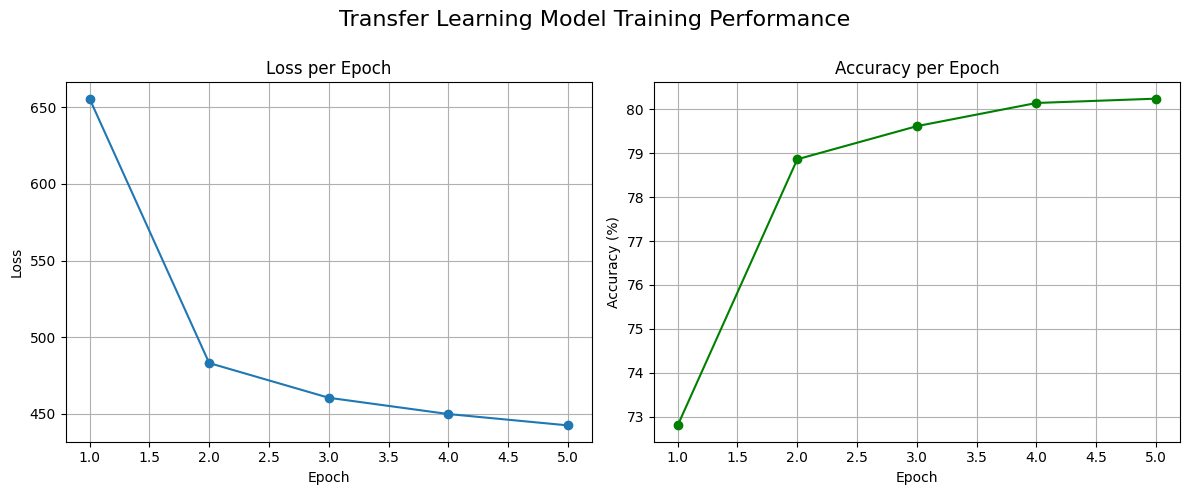

In [ ]:
plot_performance(train_losses, train_accuracies, title="Transfer Learning Model Training Performance")

The plots show the training loss and training accuracy over five epochs.

The left plot illustrates how the training loss decreases sharply from 656 in the first epoch to about 483 in the second, then continues to decline more gradually, reaching 442 by the fifth epoch. This downward trend indicates that the model is learning and optimizing effectively as training progresses.

The right plot shows a consistent improvement in training accuracy, rising from roughly 72.8% in the first epoch to just above 80.2% in the fifth. The accuracy increase is steep initially and then begins to plateau, suggesting diminishing returns in performance gains per epoch.

Overall, the plots reflect a successful training process with typical convergence behavior: decreasing loss and increasing accuracy over time.

### Test Model Accuracy

Now we evaluate the modified ResNet-18 model on the test set.

In [ ]:
import time

resnet18.eval()  # Set the model to evaluation mode (disables dropout, batchnorm updates, etc.)

n_correct = 0     # Count of correct predictions
n_total = 0       # Total number of samples processed
mistakes = []     # List to store misclassified samples

start_time = time.time()  # Start timing the evaluation

# Disable gradient calculation for inference (saves memory and computation)
with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet18(images)                      # Forward pass
        probs = torch.softmax(outputs, dim=1)           # Convert logits to probabilities
        max_probs, predicted = torch.max(probs, dim=1)  # Predicted class and confidence

        n_total += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        # Identify incorrect predictions
        wrong_mask = (predicted != labels)

        # Store confidence, predicted label, true label, and image for mistakes
        mistakes_zip = zip(max_probs[wrong_mask], predicted[wrong_mask], labels[wrong_mask], images[wrong_mask])
        for prob, pred_class, true_class, img in mistakes_zip:
            mistakes.append((prob.item(), pred_class.item(), true_class.item(), img.cpu()))

        # Update the test accuracy
        current_accuracy = 100 * n_correct / n_total
        loop.set_postfix(accuracy=current_accuracy)


eval_duration = time.time() - start_time
eval_duration_str = f"{eval_duration / 60:.2f} minutes" if eval_duration > 60 else f"{eval_duration:.2f} seconds"
print(f"Test Accuracy: {current_accuracy:.2f}% - Evaluation took {eval_duration_str}")


Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 80.51% - Evaluation took 29.97 seconds


The model achieved an accuracy above 80%.

### Top-10 Mistakes

In this section, we identify the 10 biggest mistakes made by the model — images that it classified with high confidence but assigned to the wrong class.

We do this by sorting the mistakes (i.e., misclassified samples) collected in the previous section, in descending order of the model's prediction confidence, to find the most confident incorrect predictions.

In [ ]:
mistakes.sort(key=lambda x: x[0], reverse=True)
top_10_mistakes = mistakes[:10]  # Select the top 10 most confident incorrect predictions

for i, (prob, pred_class, true_class, _) in enumerate(top_10_mistakes):
    print(f"Top {i+1} Mistake: Predicted={pred_class}, True={true_class}, Confidence={prob:.4f}")

Top 1 Mistake: Predicted=8, True=0, Confidence=0.9999
Top 2 Mistake: Predicted=1, True=9, Confidence=0.9993
Top 3 Mistake: Predicted=4, True=2, Confidence=0.9982
Top 4 Mistake: Predicted=1, True=9, Confidence=0.9982
Top 5 Mistake: Predicted=6, True=3, Confidence=0.9972
Top 6 Mistake: Predicted=4, True=5, Confidence=0.9956
Top 7 Mistake: Predicted=8, True=0, Confidence=0.9954
Top 8 Mistake: Predicted=2, True=6, Confidence=0.9954
Top 9 Mistake: Predicted=3, True=5, Confidence=0.9946
Top 10 Mistake: Predicted=1, True=9, Confidence=0.9940


### Show Mistakes

Now, we display the images along with their predicted class by the model and their true class labels.

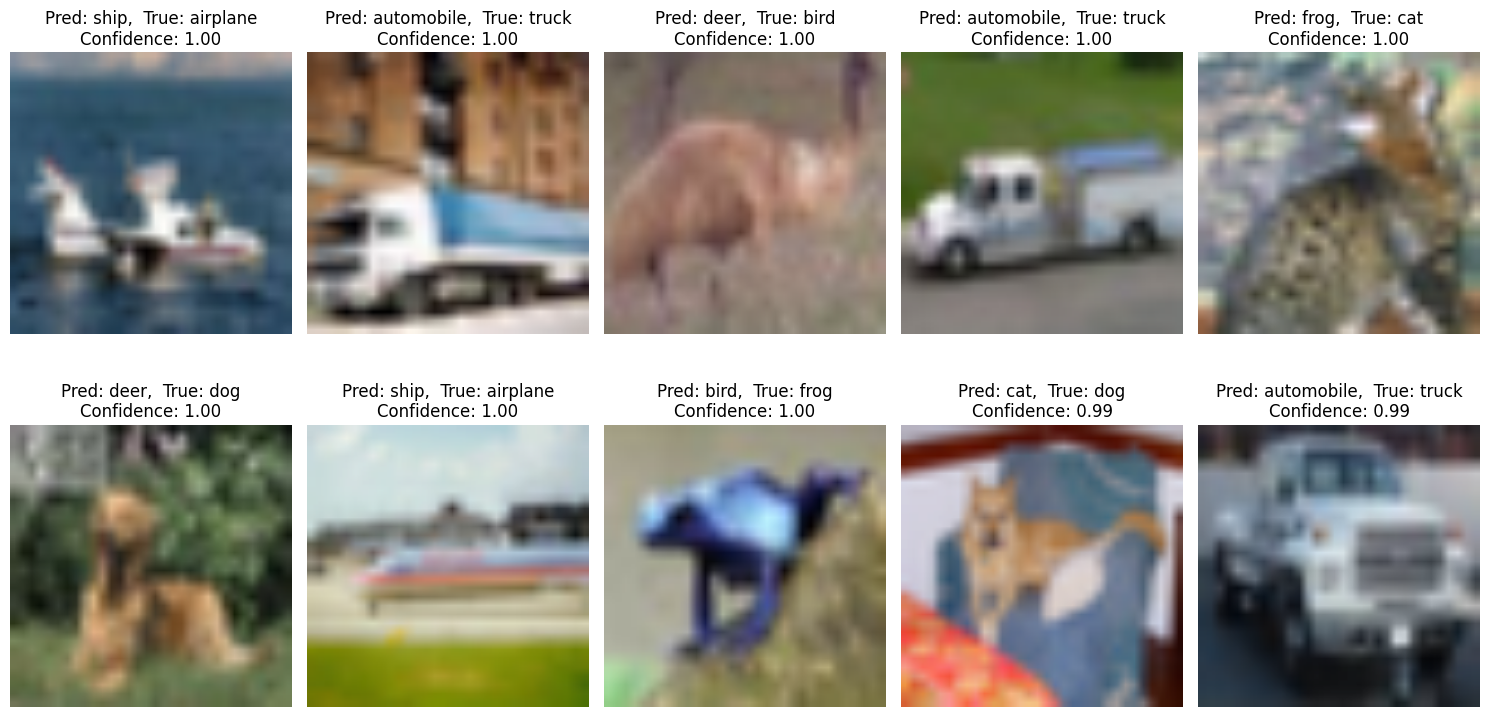

In [ ]:
plt.figure(figsize=(15, 8))

for i, (prob, pred_class, true_class, img) in enumerate(top_10_mistakes):
    plt.subplot(2, 5, i + 1)
    img_np = img.permute(1, 2, 0).numpy()

    # Undo normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.title(f"Pred: {test_set.classes[pred_class]},  True: {test_set.classes[true_class]}\nConfidence: {prob:.2f}")
    plt.axis('off')

plt.tight_layout()
plt.show()

The image shows several model misclassifications, some of which are understandable. Notably, the model predicted "ship" with 1.00 confidence for an image of a seaplane — an airplane that lands on water — which is surrounded by a sea-blue background. This context likely misled the model, as the visual cues are more typical of ships than planes.

Additionally, the model mislabeled three trucks as "automobiles" with high confidence. This confusion is reasonable since both classes share similar structural features like wheels, cabins, and road settings. The blurry or partial views of the vehicles may further obscure class-specific details, making them harder to distinguish.

Several animals were misclassified with high confidence, likely due to pose, blur, or occlusion. For example, a curled-up or blurred cat may lack clearly visible feline features. Similarly, a frog misclassified as a "bird" could be due to unusual coloring and body posture.

Overall, most errors stem from visual ambiguity, motion blur, or overlapping features between classes — all challenges common in small, low-resolution image datasets like CIFAR-10.

### Downsampling and Adaptive Pooling

In this section, we are asked to create a new model that gets the same input as the previous model, consisting of a sequence of three residual blocks that reduce the spatial dimensions (height and width), followed by an adaptive average pooling layer and a classification head.

#### Implementing Residual Block

Before we build the full model, we need a reusable residual block. This block will optionally reduce the spatial dimensions of the input (i.e., downsample) while maintaining the skip connection.

In [ ]:
class ResidualBlock(nn.Module):
    """
    A residual block with optional downsampling that supports skip connections.

    Args:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.
        downsample (bool): Whether to downsample the spatial resolution (H and W).
    """
    def __init__(self, in_channels: int, out_channels: int, downsample: bool = False) -> None:
        super().__init__()
        stride = 2 if downsample else 1

        # First convolution: optional downsampling with stride
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # Second convolution: keeps the same spatial size
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Optional projection shortcut (1x1 conv) for matching dimensions
        self.downsample = None
        if downsample or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the residual block.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output tensor after applying the residual block
        """
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.downsample(x) if self.downsample else x  # Add skip connection
        return self.relu(out)

The `__init__` method initializes two convolution layers with batch normalization and ReLU. If the input and output shapes differ (due to `downsample=True` or channel size mismatch), it adds a downsampling path using a 1x1 convolution to match dimensions.

The `forward` method applies the two convolution layers with batch norm and ReLU. Adds the shortcut connection (identity) to the output. Applies ReLU again to the summed output.

This block is the building unit of the full network and includes optional downsampling to reduce width & height.

#### Build a Custom ResNet with 3 Residual Blocks

The following class implements the complete model that gets the input image and passes it through three residual blocks, each reducing the spatial size.

In [ ]:
class CustomResNet(nn.Module):
    """
    A simplified ResNet-style model with 3 residual blocks, adaptive average pooling,
    and a linear classification head.

    Args:
        in_channels (int): Number of input image channels (e.g., 3 for RGB).
        num_classes (int): Number of output classes for classification.
    """
    def __init__(self, in_channels: int = 3, num_classes: int = 10) -> None:
        super().__init__()

        # Residual blocks, each reducing spatial dimensions
        self.block1 = ResidualBlock(in_channels, 64, downsample=True)
        self.block2 = ResidualBlock(64, 128, downsample=True)
        self.block3 = ResidualBlock(128, 256, downsample=True)

        # Adaptive pooling to reduce (H, W) to (1, 1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classification head
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the full model.

        Args:
            x (torch.Tensor): Input tensor of shape (B, C, H, W)

        Returns:
            torch.Tensor: Output logits of shape (B, num_classes)
        """
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

The `__init__` method defines 3 residual blocks, each reducing the spatial dimensions:

- Block1: Input → 64 channels, downsample
- Block2: 64 → 128 channels, downsample
- Block3: 128 → 256 channels, downsample

Then, it adds an adaptive average pooling layer to convert the feature map to 1x1 spatial size.
And finally it defines a fully connected (linear) classification head with output size = `num_classes`.

The `forward` method passes input through the 3 blocks, applies adaptive pooling and flattens the tensor, and feeds it into the fully connected layer to get class predictions.

#### To Sum Up

We construct a new convolutional neural network model composed of the following components:

- **Three residual blocks:** Each block reduces the spatial dimensions (height and width) of the input using strided convolutions. These blocks also use skip connections, allowing the model to learn identity mappings and mitigate vanishing gradient problems, which is a hallmark of ResNet architectures.

- **Adaptive average pooling:** After the residual blocks, an `AdaptiveAvgPool2d` layer reduces the feature maps to a spatial size of 1x1, regardless of the original input size. This makes the model more flexible to different input dimensions and reduces the number of parameters in the fully connected layer.

- **Classification head:** A single linear layer takes the pooled features and outputs logits corresponding to the target number of classes. This is suitable for classification tasks.

By using three residual blocks that progressively reduce spatial resolution and increasing the number of channels, followed by global pooling and a classification layer, this model matches the architectural requirements described in the question.

### Train the New Model

#### Training Setup

Set up the training environment by:

1. Selecting a computation device — a GPU if available, otherwise CPU.

2. Initialize the model with the specified number of output classes and moves it to the chosen device.

3. The loss function used is CrossEntropyLoss, which is suitable for multi-class classification problems.

4. The Adam optimizer is defined to update the model's parameters during training, using a learning rate of 0.001. The learning rate we had good performacne with the the previous model.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
new_model = CustomResNet(num_classes=n_classes).to(device)
new_criterion = nn.CrossEntropyLoss()
new_optimizer = optim.Adam(new_model.parameters(), lr=0.001)

#### Model Training

In [ ]:
import time
from tqdm.notebook import tqdm

new_model.train()

n_epochs = 30           # Set sufficient amount of epochs to reach 70% accuracy
target_accuracy = 70.0  # Stop training once this accuracy is reached
target_reached = False

new_train_losses = []
new_train_accuracies = []

for epoch in range(1, n_epochs + 1):
    epoch_loss, n_correct, n_total = 0.0, 0, 0

    start_time = time.time()  # Start timing the epoch

    # Batch training loop
    loop = tqdm(train_loader, desc=f"Epoch {epoch} / {n_epochs}")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        # Learning process
        new_optimizer.zero_grad()               # Clear gradients before backpropagation
        outputs = new_model(images)             # Forward pass
        loss = new_criterion(outputs, labels)   # Compute loss
        loss.backward()                         # Backward pass
        new_optimizer.step()                    # Update weights

        # Accumulate stats
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        n_total += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        current_accuracy = 100 * n_correct / n_total

        # Update tqdm description
        loop.set_postfix(loss=epoch_loss, accuracy=current_accuracy)
        if current_accuracy > target_accuracy and not target_reached:
            print(f"Target accuracy reached! Training will stop after this batch.")
            target_reached = True

    # Log epoch time
    epoch_duration = time.time() - start_time  # End timing
    epoch_duration_str = f"{epoch_duration / 60:.2f} minutes" if epoch_duration > 60 else f"{epoch_duration:.2f} seconds"
    print(f"Epoch {epoch}/{n_epochs} took {epoch_duration_str}")

    # Record epoch loss and accuracy
    new_train_losses.append(epoch_loss)
    new_train_accuracies.append(current_accuracy)  # Last accuracy calculated is the epoch accuracy

    # Stop training early if target accuracy is reached
    if target_reached:
        print(f"Target accuracy of {target_accuracy:.2f}% reached at epoch {epoch}.")
        break

Epoch 1 / 30:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1/30 took 4.31 minutes


Epoch 2 / 30:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/30 took 4.34 minutes


Epoch 3 / 30:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/30 took 4.34 minutes


Epoch 4 / 30:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/30 took 4.32 minutes


Epoch 5 / 30:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/30 took 4.30 minutes


Epoch 6 / 30:   0%|          | 0/782 [00:00<?, ?it/s]

Target accuracy reached! Training will stop after this batch.
Epoch 6/30 took 4.33 minutes
Target accuracy of 70.00% reached at epoch 6.


#### Plot Training Performance

We use the `plot_performance` function to assess the new model's loss and accuracy trends across epochs.

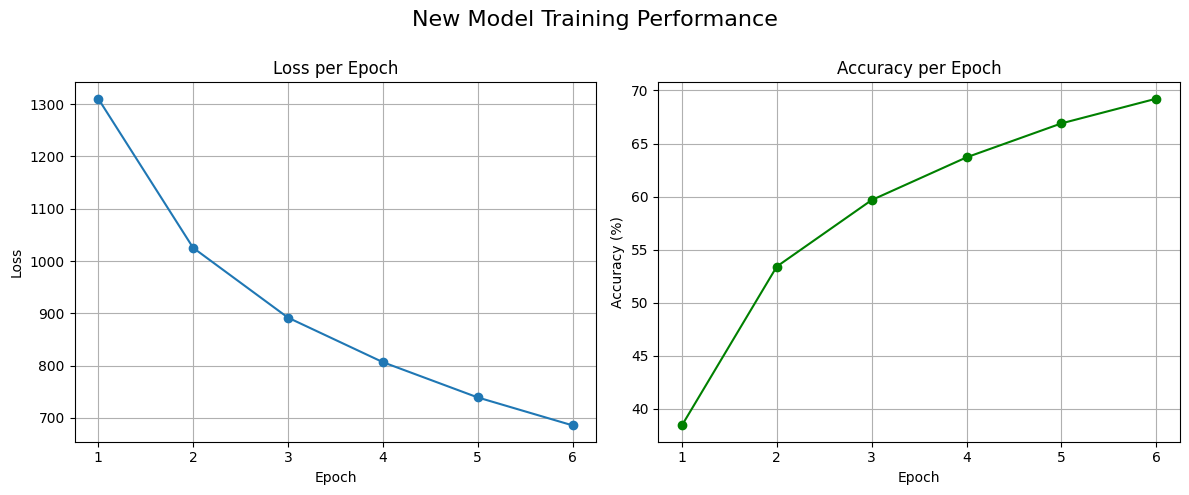

In [ ]:
plot_performance(new_train_losses, new_train_accuracies, title="New Model Training Performance")

The new model training performance plots show steady and consistent improvement across epochs.

The loss curve (left) exhibits a smooth and continual decrease from over 1300 to around 690, indicating that the model is learning effectively without signs of instability or overfitting.

Simultaneously, the accuracy curve (right) rises progressively from 39% to just below 70%, showing that the model's predictive performance is steadily improving.

The shape of both curves suggests that further training may yield continued gains, although the rate of improvement is beginning to taper off slightly. Overall, the training progress appears healthy and well-behaved, albeit very gradual and slow.

#### New Model Evaluation

Now we evaluate the modified ResNet-18 model on the test set.

In [ ]:
import time

new_model.eval()  # Set the model to evaluation mode

n_correct = 0     # Count of correct predictions
n_total = 0       # Total number of samples processed
mistakes = []     # List to store misclassified samples

start_time = time.time()  # Start timing the evaluation

# Saves memory and computation by disabling gradient calculation for inference
with torch.no_grad():
    loop = tqdm(test_loader, desc="Evaluating")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        outputs = new_model(images)                     # Forward pass
        probs = torch.softmax(outputs, dim=1)           # Convert logits to probabilities
        max_probs, predicted = torch.max(probs, dim=1)  # Predicted class and confidence

        n_total += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        # Identify incorrect predictions
        wrong_mask = (predicted != labels)

        # Store confidence, predicted label, true label, and image for mistakes
        mistakes_zip = zip(max_probs[wrong_mask], predicted[wrong_mask], labels[wrong_mask], images[wrong_mask])
        for prob, pred_class, true_class, img in mistakes_zip:
            mistakes.append((prob.item(), pred_class.item(), true_class.item(), img.cpu()))

        # Update the test accuracy
        current_accuracy = 100 * n_correct / n_total
        loop.set_postfix(accuracy=current_accuracy)


eval_duration = time.time() - start_time
eval_duration_str = f"{eval_duration / 60:.2f} minutes" if eval_duration > 60 else f"{eval_duration:.2f} seconds"
print(f"Test Accuracy: {current_accuracy:.2f}% - Evaluation took {eval_duration_str}")

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Accuracy: 64.79% - Evaluation took 30.57 seconds


### Model Comparison and Selection

When comparing the two models, key differences emerge in training efficiency, accuracy, and inference speed. The first model achieves strong results quickly, surpassing 80% train and test accuracy within just 5 epochs, with each epoch taking approximately 2.2 minutes. In contrast, the second model trains for 6 epochs at 4.3 minutes per epoch and only reaches 64.79% test accuracy, indicating a slower and less effective learning process despite its steady improvement.

From a training efficiency standpoint, the first model is clearly superior. It not only converges faster but also achieves a much higher level of performance in less than half the time per epoch. This makes it especially suitable in scenarios where the model needs to be retrained often, such as with evolving datasets or in a development environment with frequent experimentation.

In terms of inference speed, the two models are nearly identical, with the first model taking 29.97 seconds and the second 30.57 seconds to perform inference. This negligible difference is unlikely to matter in most real-world applications and certainly does not compensate for the second model's significantly lower accuracy.

Therefore, **the first model is the better overall choice**. It delivers higher performance in both training and testing, and it does so more efficiently. This highlights the power of transfer learning — leveraging a pretrained model allows for faster convergence and better generalization, even with limited training on a new dataset.

**Key Differences**

Notation:
- Model 1 ← Transfer Learning Model
- Model 2 ← Custom Residual Model

Training Time per Epoch:
- Model 1: ~2.2 minutes per epoch
- Model 2: ~4.3 minutes per epoch

Training Duration to Reach Performance:
-  Model 1: Achieved >80% train and test accuracy in 5 epochs (~11 minutes total)
- Model 2: Reached only 64.79% test accuracy after 6 epochs (~26 minutes total)

Final Test Accuracy:
- Model 1: >80%
- Model 2: 64.79%

Training Efficiency:
- Model 1: Learns quickly and converges efficiently
- Model 2: Slower learning curve, lower overall performance

Inference/Prediction Time:
- Model 1: ~29.97 seconds
- Model 2: ~30.57 seconds